In [81]:
from oiforests.liu import LiuIsolationForest
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

# Generate 2-dimensional test data

We can generate many types of data. Here are two synthetic examples. Pick one and execute it.

## Single Gaussian for Typical and Anomalous 

In [176]:
counts = 10000
anomalous_rate = 0.01
anomalous_mean, anomalous_sigma = (5,2.5), (5,2)
typical_mean, typical_sigma = (0,0), (1,1)

typical_rate = 1 - anomalous_rate
anomalous_count = np.random.binomial(counts, anomalous_rate)
typical_count = counts - anomalous_count

anomalous_data = np.stack([np.random.normal(m, s, size=anomalous_count) 
                           for m, s in zip(anomalous_mean, anomalous_sigma)], axis=1)
typical_data = np.stack([np.random.normal(m, s, size=typical_count) 
                      for m, s in zip(typical_mean, typical_sigma)], axis=1)
X = np.concatenate([anomalous_data, typical_data])
np.random.shuffle(X)

## Mixture of Gaussians 

In [386]:
counts = 10000
anomalous_rate = 0.01
anomalous_components = [((20,-20), (0.5,0.5), 0.1), ((0,0), (10,10), 0.9)]

segments = 100
half_segments = segments//2
v = np.random.random(segments) + 0.1
v = v/np.sum(v)
typical_components = [((15*np.cos(i*2*np.pi/half_segments), 15*np.sin(i*2*np.pi/half_segments)), (1, 1), v[i]) 
                      for i in range(half_segments)]

typical_components += [((5*np.cos(i*2*np.pi/half_segments), 5*np.sin(i*2*np.pi/half_segments)), (0.1, 0.1), v[i]) 
                      for i in range(half_segments, segments)]

#typical_components = [((0,0),(1,1), 0.25), ((10,10),(1,1), 0.75)]

typical_rate = 1 - anomalous_rate
anomalous_count = np.random.binomial(counts, anomalous_rate)
typical_count = counts - anomalous_count

def generate(components, n=100):
    ps = [p for _, _, p in components]
    counts = np.random.multinomial(n, ps)
    single = lambda i: np.array([np.random.normal(m, s) for m, s in zip(components[i][0], components[i][1])])
    many = lambda i, k: np.stack([single(i) for _ in range(k)], axis=0)
    return np.concatenate([many(i, c) for i, c in enumerate(counts)])


anomalous_data = generate(anomalous_components, anomalous_count)
typical_data = generate(typical_components, typical_count)
X = np.concatenate([anomalous_data, typical_data])
np.random.shuffle(X)

# Plot 

We can inspect the data we generated. 

<IPython.core.display.Javascript object>


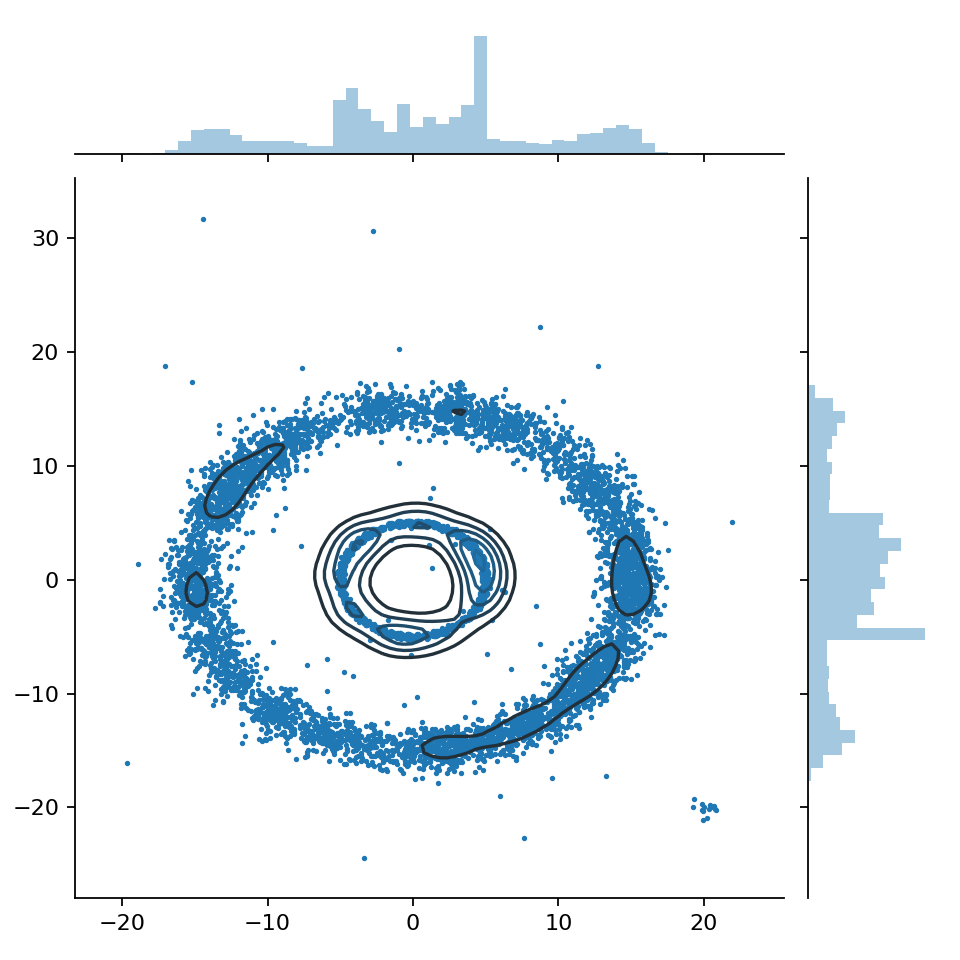

In [387]:
g = (sns.jointplot(x=X1[:,0], y=X[:,1], s=2).plot_joint(sns.kdeplot, n_levels=5))

#  Test

Now let's test it with an isolation forest!

In [423]:
f = LiuIsolationForest(max_depth=5, tree_count=100, subsample_size=255)
f.fit(X)

## Scores

We can plot the actual scores of all the points. 

<IPython.core.display.Javascript object>


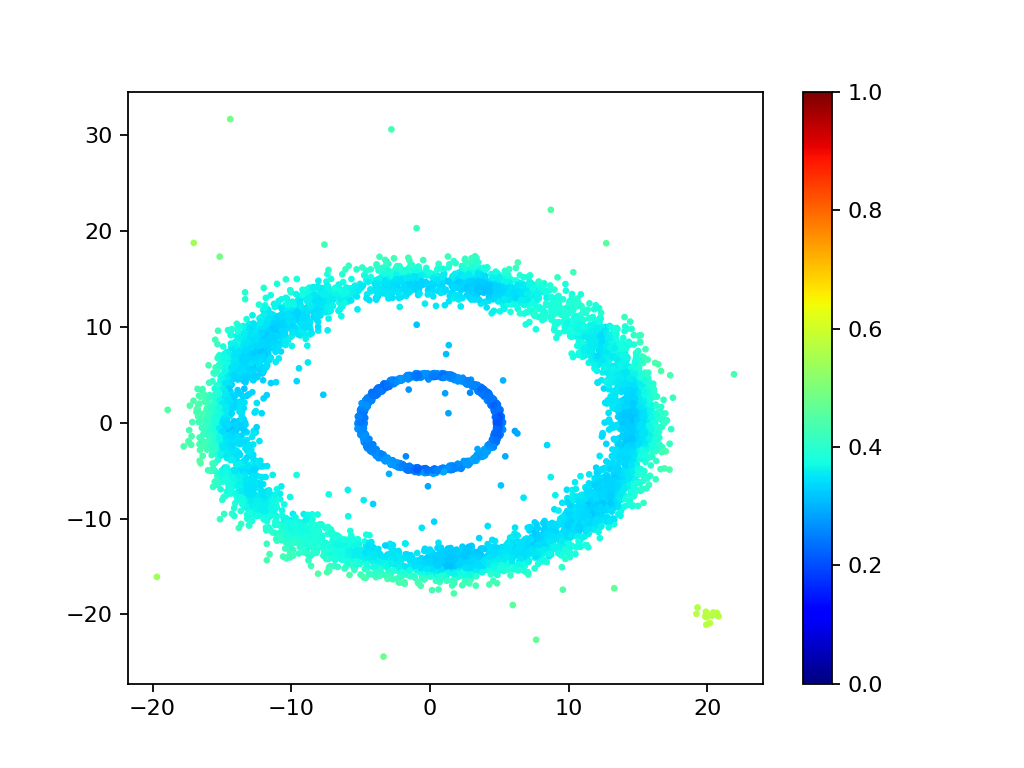

In [424]:
scores = np.array([f.score(x) for x in X])
fig, ax = plt.subplots()
im = ax.scatter(X[:,0], X[:,1], c=scores, s=4,vmin=0, vmax=1, cmap='jet')
fig.colorbar(im)
fig.show()

## Anomaly map 

We can plot an anomaly map of a grid over the data.

<IPython.core.display.Javascript object>


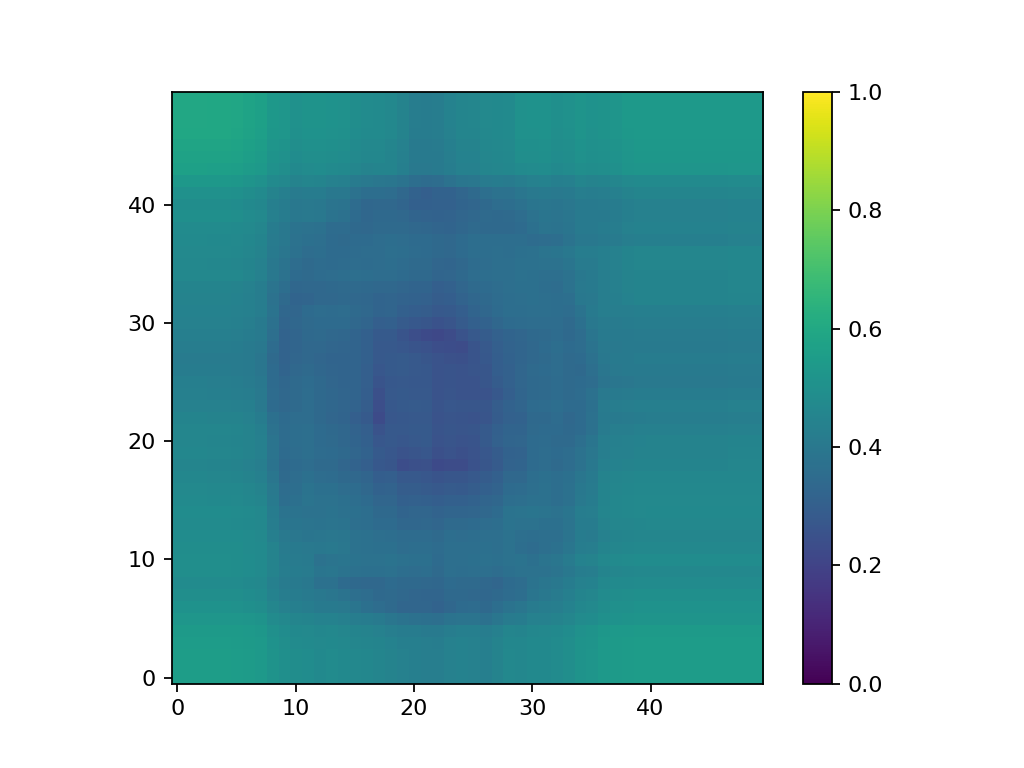

In [421]:
resolution=50
scores = np.zeros((resolution, resolution))
xgrid = np.linspace(np.min(X[:,0]), np.max(X[:,0]), resolution)
ygrid = np.linspace(np.min(X[:,1]), np.max(X[:,1]), resolution)
xv, yv = np.meshgrid(xgrid, ygrid)
positions = np.stack([xv.ravel(), yv.ravel()], axis=1)

for xx, yy in positions:
    xi = np.argmax(xgrid == xx)
    yi = np.argmax(ygrid == yy)

    scores[xi,yi] = f.score(np.array([xx,yy]))
    
fig, ax = plt.subplots()
im = ax.imshow(scores, origin='lower', vmin=0, vmax=1)
fig.colorbar(im)
fig.show()